In [1]:
!pip install keras_core
!pip install keras-cv
!pip install matplotlib

  Obtaining dependency information for keras_core from https://files.pythonhosted.org/packages/d4/fe/79a7400420b1cbe772b45fad693693bdd02597a0a45100ab3f25b76e5cb7/keras_core-0.1.4-py3-none-any.whl.metadata
  Obtaining dependency information for rich from https://files.pythonhosted.org/packages/8d/5f/21a93b2ec205f4b79853ff6e838e3c99064d5dbe85ec6b05967506f14af0/rich-13.5.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 21.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.7/239.7 kB 58.1 MB/s eta 0:00:00
  Obtaining dependency information for keras-cv from https://files.pythonhosted.org/packages/ff/5e/bccabe268ea0fb950b8af780f9f6191760629de6af54da7fc90dd69b9f57/keras_cv-0.6.1-py3-none-any.whl.metadata
  Obtaining dependency information for regex from https://files.pythonhosted.org/packages/d1/df/460ca6171a8494fcf37af43f52f6fac23e38784bb4a26563f6fa01ef6faf/regex-2023.8.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.me

In [4]:
import random

import keras
import keras_cv
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

2023-08-23 03:22:06.559085: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Image Config
HEIGHT = 160
WIDTH = 160
NUM_CLASSES = 3

# Augmentation Config
ROTATION_FACTOR = (-0.2, 0.2)

# Training Config
BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
tfds.disable_progress_bar()
orig_train_ds, orig_val_ds = tfds.load(
    name="oxford_iiit_pet",
    split=["train+test[:80%]", "test[80%:]"],
)

2023-08-23 03:22:15.466656: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


2023-08-23 03:25:17.668041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38319 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


In [11]:
tfds.disable_progress_bar()
orig_train_ds, orig_val_ds = tfds.load(
    name="oxford_iiit_pet",
    split=["train+test[:80%]", "test[80%:]"],
)

In [12]:
rescale_images_and_correct_masks = lambda inputs: {
    "images": tf.cast(inputs["image"], dtype=tf.float32) / 255.0,
    "segmentation_masks": inputs["segmentation_mask"] - 1,
}

train_ds = orig_train_ds.map(
    rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE
)
val_ds = orig_val_ds.map(rescale_images_and_correct_masks, num_parallel_calls=AUTOTUNE)

In [13]:

def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks


2023-08-23 03:27:46.360023: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]
2023-08-23 03:27:46.360460: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [8]
	 [[{{node Placeholder/_3}}]]


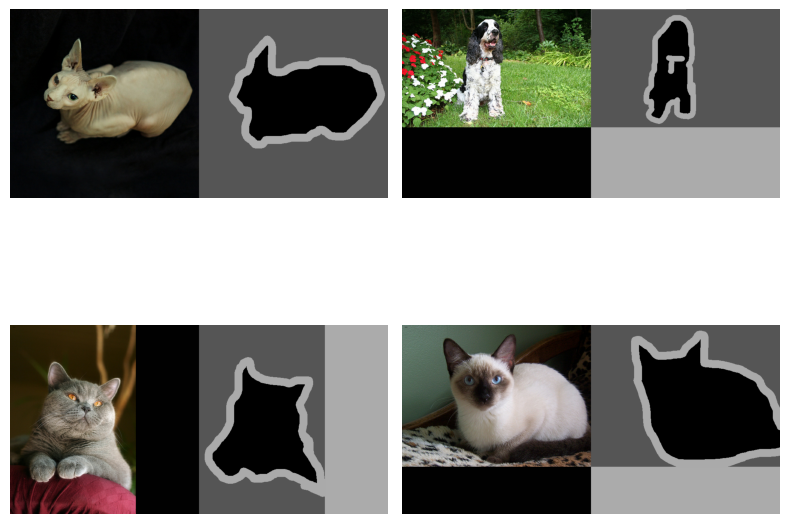

In [14]:
plot_train_ds = train_ds.map(unpackage_inputs).ragged_batch(4)
images, segmentation_masks = next(iter(plot_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)

In [15]:
resize_fn = keras_cv.layers.Resizing(
    HEIGHT,
    WIDTH,
)

augment_fn = keras.Sequential(
    [
        resize_fn,
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomRotation(
            factor=ROTATION_FACTOR,
            segmentation_classes=NUM_CLASSES,
        ),
#         keras_cv.layers.RandAugment(
#             value_range=(0, 1),
#             geometric=False,
#         ),
    ]
)

In [16]:
augmented_train_ds = (
    train_ds.shuffle(BATCH_SIZE * 2)
    .map(augment_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

resized_val_ds = (
    val_ds.map(resize_fn, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

2023-08-23 03:27:55.591363: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [8]
	 [[{{node Placeholder/_4}}]]
2023-08-23 03:27:55.593168: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_26' with dtype resource
	 [[{{node Placeholder/_26}}]]
2023-08-23 03:27:56.209741: I tensorflow/core/common_runtime/executor.cc:1209] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_11}}]] [type.goo

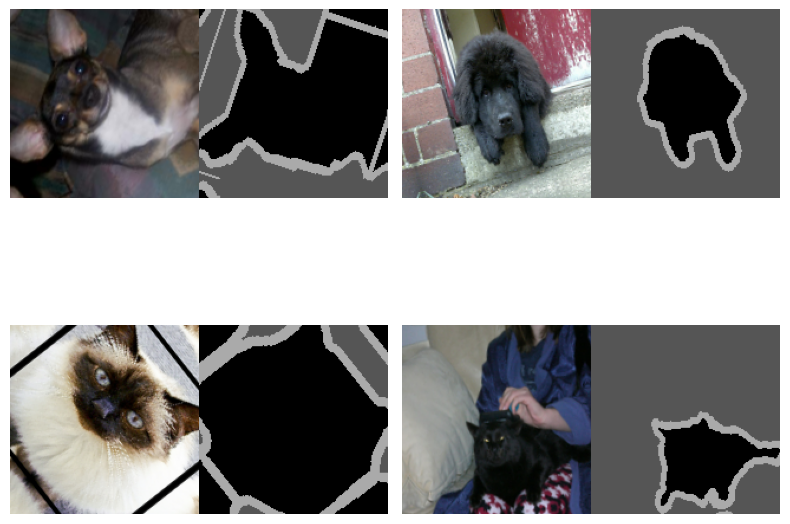

In [17]:
images, segmentation_masks = next(iter(augmented_train_ds.take(1)))

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 1),
    num_classes=3,
    y_true=segmentation_masks,
    y_pred=None,
    scale=4,
    rows=2,
    cols=2,
)

In [18]:

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Taking a batch of test inputs to measure model's progress.
test_images, test_masks = next(iter(resized_val_ds))


2023-08-23 03:27:59.735129: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-08-23 03:27:59.735546: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


In [19]:

class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            pred_masks = self.model.predict(test_images)
            pred_masks = tf.math.argmax(pred_masks, axis=-1)
            pred_masks = pred_masks[..., tf.newaxis]

            # Randomly select an image from the test batch
            random_index = random.randint(0, BATCH_SIZE - 1)
            random_image = test_images[random_index]
            random_pred_mask = pred_masks[random_index]
            random_true_mask = test_masks[random_index]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
            ax[0].imshow(random_image)
            ax[0].set_title(f"Image: {epoch:03d}")

            ax[1].imshow(random_true_mask)
            ax[1].set_title(f"Ground Truth Mask: {epoch:03d}")

            ax[2].imshow(random_pred_mask)
            ax[2].set_title(
                f"Predicted Mask: {epoch:03d}",
            )

            plt.show()
            plt.close()


callbacks = [DisplayCallback(5)]

2023-08-23 03:28:03.788410: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]
2023-08-23 03:28:03.788933: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]


Epoch 1/5


2023-08-23 03:28:07.113060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


4/4 [==============================] - 1s 10ms/steploss: 1.5585 - accuracy: 0.60


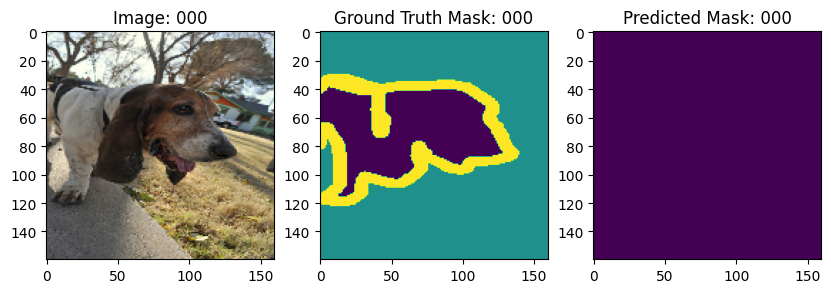

52/52 [==============================] - 20s 274ms/step - loss: 1.5585 - accuracy: 0.6090 - val_loss: 1.2570 - val_accuracy: 0.5740
Epoch 2/5
 1/52 [..............................] - ETA: 23s - loss: 0.9275 - accuracy: 0.6631

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/52 [==============================] - 10s 185ms/step - loss: 0.8514 - accuracy: 0.6767 - val_loss: 2.0708 - val_accuracy: 0.5740
Epoch 3/5
 3/52 [>.............................] - ETA: 8s - loss: 0.8050 - accuracy: 0.6867 

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/52 [==============================] - 10s 183ms/step - loss: 0.7623 - accuracy: 0.6991 - val_loss: 2.7466 - val_accuracy: 0.5740
Epoch 4/5
 3/52 [>.............................] - ETA: 6s - loss: 0.7229 - accuracy: 0.7105

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/52 [==============================] - 8s 139ms/step - loss: 0.7119 - accuracy: 0.7146 - val_loss: 3.2466 - val_accuracy: 0.5740
Epoch 5/5
 4/52 [=>............................] - ETA: 6s - loss: 0.6814 - accuracy: 0.7239

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


52/52 [==============================] - 9s 161ms/step - loss: 0.6807 - accuracy: 0.7253 - val_loss: 3.3748 - val_accuracy: 0.5740


In [20]:
# Build model
model = get_model(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model, doing validation at the end of each epoch.
history = model.fit(
    augmented_train_ds,
    epochs=EPOCHS,
    validation_data=resized_val_ds,
    callbacks=callbacks,
)

4/4 [==============================] - 0s 13ms/step


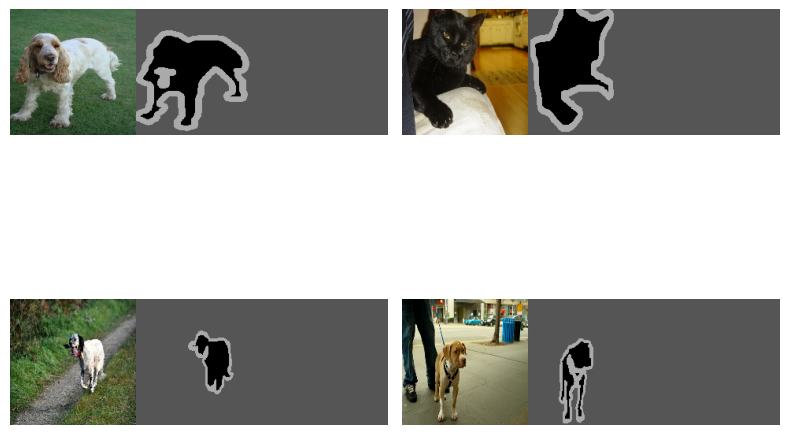

In [21]:
pred_masks = model.predict(test_images)
pred_masks = tf.math.argmax(pred_masks, axis=-1)[..., None]

keras_cv.visualization.plot_segmentation_mask_gallery(
    test_images,
    value_range=(0, 1),
    num_classes=3,
    y_true=test_masks,
    y_pred=pred_masks,
    scale=4,
    rows=2,
    cols=2,
)